<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 2: Sem2 AY 24/25 - DQN for Atari

Module Leader: J.J. Collins

Submitted by: Thendral Balakrishnan (Student ID: **24128902**)
Github Repository containing all program files and code: 

### **Introduction**

The objective of this project is to train a Reinforcement Learning (RL) agent to play the Atari game *Breakout* using the Deep Q-Network (DQN) algorithms. This task involves the implementation and evaluation of different variants of the DQN algorithm using the OpenAI Gym environment.

Reinforcement Learning is well-suited for this problem because the agent must learn to make sequential decisions in an environment where the dynamics are unknown and rewards are sparse. The agent observes the game screen (state), selects paddle movements (actions), and receives rewards based on how long it survives and how many bricks it breaks.

**The project explores:**
- Vanilla DQN
- Double DQN
- Dueling DQN
- A combined Double + Dueling DQN
- Double DQN with Prioritized Experience Replay (PER)

Each method is evaluated based on its ability to learn optimal policies over multiple training episodes, with performance measured through average reward and training stability.

**References:**
- [Github: GiannisMitr/DQN-Atari-Breakout](https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_atari_breakout.ipynb)
- [Github: KJ-Waller/DQN-PyTorch-Breakout](https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py)
- [Github: AlpayAriyak/Atari-Advanced DQN](https://github.com/alpayariyak/Atari-Advanced-DQN/blob/master/environment.py)
- [A Geron's Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow - Chapter 18 Reinforcement Learning sample notebook](https://github.com/ageron/handson-ml2/blob/8958d538bdcdf29d329d9950bfc79034c29db724/18_reinforcement_learning.ipynb)
- [DQN Tutorial | Pytorch.org](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)



**Environment Description**

The environment used for this project is the Atari game *Breakout*, provided by the Gymnasium library.

**a. The Atari Game Selected**
*Breakout* is a classic arcade game where the agent controls a paddle at the bottom of the screen and aims to bounce a ball upward to break bricks. The goal is to maximize the score by breaking as many bricks as possible without losing the ball.

**b. Inputs Received from the Environment**
The environment provides frames from the game as raw pixel observations. These are typically grayscale image arrays of size (84 × 84), stacked across the last four frames to incorporate temporal information. Each frame serves as a state input for the Deep Q-Network.

**c. Control Settings for the Joystick**
The agent can choose from the following discrete actions:
- 0: NOOP (no action)
- 1: FIRE (launches the ball)
- 2: RIGHT (move paddle right)
- 3: LEFT (move paddle left)

The action space is Discrete(4), and the environment is reset automatically at the beginning of each episode.


Gymnasium Documentation: [https://ale.farama.org/environments/](https://ale.farama.org/environments/) [Accessed: May 2025]


### Import Dependencies

In [2]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from datetime import datetime
from skimage.transform import resize
from skimage.color import rgb2gray
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import pandas as pd
import matplotlib.pyplot as plt

/home/sprince0031/.local/lib/python3.10/site-packages/tensorflow/__init__.py:30: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils as _distutils
2025-05-14 23:07:44.619399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 23:07:45.346842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# Automatically select GPU (if available), otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Model Components and Utilities

#### Preprocessing

The game observations are preprocessed before being fed to the DQN. 
This includes:
- Converting the RGB frame to grayscale
- Resizing to 84 × 84
- Stacking the last four frames to preserve temporal information

This is a standard preprocessing step in Atari DQN agents based on DeepMind's architecture.


In [ ]:
def preprocess_observation(obs):
    gray = rgb2gray(obs)
    resized = resize(gray, (84, 84), mode='constant')
    return np.uint8(resized * 255)

#### Experience Replay Buffers

Two types of experience replay buffers are used in this project:

1. **ReplayBuffer** – uniform random sampling from a fixed-size buffer
2. **PrioritizedReplayBuffer** – samples important transitions more frequently based on TD error

Experience replay improves sample efficiency and breaks correlation between consecutive transitions.


In [11]:
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)
    
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha  # controls how much prioritization is used
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0

    def __len__(self):
        return len(self.buffer)


    def add(self, transition, td_error=1.0):
        max_priority = max(self.priorities.max(), td_error)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.pos]

        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()  # normalize for stability

        return samples, indices, weights

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-5  # small constant to avoid zero
    


#### Deep Q-Network Architecture

The neural network approximates the Q-function \( Q(s, a) \) and follows the DeepMind DQN design. 
It also optionally supports the **Dueling DQN** structure, which separates the state-value and action-advantage streams.

In [12]:
class DQN(nn.Module):
    def __init__(self, action_space, dueling=False):
        super(DQN, self).__init__()
        self.dueling = dueling
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        if self.dueling:
            self.value = nn.Linear(512, 1)
            self.advantage = nn.Linear(512, action_space)
        else:
            self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))

        if self.dueling:
            value = self.value(x)
            advantage = self.advantage(x)
            return value + (advantage - advantage.mean(dim=1, keepdim=True))
        else:
            return self.fc2(x)

In [8]:
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array', obs_type='rgb')
action_space = env.action_space.n
model = DQN(action_space,dueling = False)
print(model)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


#### Action Selection and Q-Value Target Calculation

The agent uses an epsilon-greedy policy to balance exploration and exploitation.
Q-value targets are computed using either standard DQN or Double DQN logic.


In [13]:
# Action Selection
def select_action(state, epsilon, action_space, policy_net):
    if random.random() < epsilon:
        return random.randrange(action_space)
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor)
        return q_values.argmax(1).item()
    
# Target Calculation
def compute_targets(batch, policy_net, target_net, gamma, double_dqn):
    states = torch.FloatTensor(np.array([b[0] for b in batch])).to(device)
    actions = torch.LongTensor(np.array([b[1] for b in batch])).to(device)
    rewards = torch.FloatTensor(np.array([b[2] for b in batch])).to(device)
    next_states = torch.FloatTensor(np.array([b[3] for b in batch])).to(device)
    dones = torch.FloatTensor(np.array([b[4] for b in batch])).to(device)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        if double_dqn:
            next_actions = policy_net(next_states).argmax(1)
            next_qs = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_qs = target_net(next_states).max(1)[0]

        targets = rewards + (1 - dones) * gamma * next_qs

    return q_values, targets


#### DQN Training Loop

This is the core loop where the agent interacts with the environment, updates the Q-network,
and periodically syncs the target network. It supports both standard and prioritized experience replay.

The training function is designed to support both Double DQN and Dueling DQN through the use of two flexible flags: `use_double_dqn` and `use_dueling_dqn`.

When `use_dueling_dqn` is set to `True`, the DQN network architecture is modified to use the **Dueling DQN structure**. This means the network separates the estimation of the overall state value from the relative advantage of each action, allowing it to learn which states are valuable even when the best action is uncertain. This setting is passed when creating the `policy_net` and `target_net`, enabling the dueling architecture internally.

The `use_double_dqn` flag controls how Q-value targets are computed during training. When it's enabled, the agent uses the **Double DQN update rule**, which selects the best next action using the policy network but evaluates that action using the target network. This helps reduce the overestimation bias that standard DQN often suffers from.

Together, these flags make it easy to switch between regular DQN, Double DQN, Dueling DQN, or a combination of both, using a single training function.



In [14]:
def train_dqn(episodes=1000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, use_per=False,save_tag='dqn'):

    env = gym.make('ALE/Breakout-v5', render_mode='rgb_array', obs_type='rgb')
    action_space = env.action_space.n
   

    policy_net = DQN(action_space, dueling=use_dueling_dqn).to(device)
    target_net = DQN(action_space, dueling=use_dueling_dqn).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    batch_size = 32
    gamma = 0.99
    target_update = 10
    alpha = 0.6
    beta_start = 0.4

    if use_per:
        replay_buffer = PrioritizedReplayBuffer(10000, alpha=alpha)
        beta_by_frame = lambda frame: min(1.0, beta_start + frame * (1.0 - beta_start) / (episodes * 1000))
    else:
        replay_buffer = ReplayBuffer(10000)

    writer = SummaryWriter(log_dir=f'runs/{save_tag}_{datetime.now().strftime("%Y%m%d_%H%M%S")}')
    best_avg_reward = -float('inf')
    reward_history = []
    step_count = 0

    for episode in range(episodes):
        obs, _ = env.reset()
        processed = preprocess_observation(obs)
        state = np.stack([processed] * 4, axis=0)
        total_reward = 0
        done = False

        while not done:
            step_count += 1
            action = select_action(state, epsilon, action_space, policy_net)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_processed = preprocess_observation(next_obs)
            next_state = np.append(state[1:], np.expand_dims(next_processed, 0), axis=0)

            if use_per:
                transition = (state, action, reward, next_state, float(done))
                replay_buffer.add(transition)  # priority added inside buffer
            else:
                replay_buffer.add((state, action, reward, next_state, float(done)))

            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                if use_per:
                    beta = beta_by_frame(step_count)
                    batch, indices, weights = replay_buffer.sample(batch_size, beta)
                    q_vals, targets = compute_targets(batch, policy_net, target_net, gamma, use_double_dqn)
                    if use_per: 
                        td_errors = (targets.detach() - q_vals.detach()).squeeze().cpu().numpy()
                    else:
                        td_errors = (targets.detach() - q_vals).squeeze().cpu().numpy()
                    weights = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device)
                    loss = (weights * (q_vals - targets.detach())**2).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    replay_buffer.update_priorities(indices, td_errors)
                else:
                    batch = replay_buffer.sample(batch_size)
                    q_vals, targets = compute_targets(batch, policy_net, target_net, gamma, use_double_dqn)
                    loss = criterion(q_vals, targets.detach())

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                writer.add_scalar('Loss/TD', loss.item(), step_count)

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        reward_history.append(total_reward)
        avg_reward = np.mean(reward_history[-50:])
        writer.add_scalar('Reward/Total', total_reward, episode)
        writer.add_scalar('Reward/Avg50', avg_reward, episode)

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save(policy_net.state_dict(), f'{save_dir}/best_{save_tag}.pth')
            print(f"[Episode {episode}] New best avg reward: {avg_reward:.2f}, model saved.")

        print(f"Episode {episode} | Total Reward: {total_reward} | Avg50: {avg_reward:.2f} | Epsilon: {epsilon:.2f}")

    env.close()
    writer.close()

#### Evaluation and Video Generation

This function loads a trained model, runs one episode in the environment, and records the gameplay to a video file.

In [15]:
# Evaluation
def evaluate_model(model_path, env_name='ALE/Breakout-v5', tag='eval', dueling=False):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=f"./videos/{tag}", episode_trigger=lambda x: True)
    action_space = env.action_space.n

    model = DQN(action_space, dueling=dueling).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    obs, _ = env.reset()
    state = np.stack([preprocess_observation(obs)] * 4, axis=0)
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_tensor).argmax(1).item()
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        processed = preprocess_observation(obs)
        state = np.append(state[1:], np.expand_dims(processed, 0), axis=0)

    env.close()
    print(f"Video saved at ./videos/{tag}")

#### Logging and Visualization 

To monitor training progress, TensorBoard was used to log key metrics such as:

- **Total reward per episode**
- **Moving average reward (Avg50)**
- **TD loss (temporal difference error)**

Logging was implemented using `SummaryWriter` from `torch.utils.tensorboard`, and scalar values were recorded at each training step or episode, depending on the metric. This allows real-time inspection of the agent's learning behavior during training.

After completing all experiments, the logged metrics were exported from TensorBoard as CSV files. These CSVs contain the `Step` and `Value` columns, which represent the x-axis (e.g., episode or step number) and the y-axis (the metric), respectively.

To view the metrics on TensorBoard, run the following command in the terminal and follow the provided link(usually localhost/6006 ): `tensorboard --logdir=runs`


In [16]:
def plot_three_metrics(
    df1, df2, df3,
    titles=["TD Loss vs Step", "Reward Avg 50 vs Episode", "Reward Total vs Episode"],
    xlabels=["Step", "Episode", "Episode"],
    ylabels=["TD Loss", "Avg 50 Reward", "Total Reward"]
):
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    dataframes = [df1, df2, df3]

    for i in range(3):
        axs[i].plot(dataframes[i]["Step"], dataframes[i]["Value"])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(xlabels[i])
        axs[i].set_ylabel(ylabels[i])
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


## Experiments and Evaluation

This section presents the training results for different variants of the Deep Q-Network (DQN) algorithm applied to the Atari game *Breakout*. The experiments are designed to evaluate how different improvements to the base DQN affect learning performance and stability.

The following configurations were tested:

- **Vanilla DQN** (1,000 and 10,000 episodes)
- **Double DQN** (1,000 and 10,000 episodes)
- **Dueling DQN** (1,000 episodes)
- **Double + Dueling DQN** (1,000 episodes)
- **Double DQN with Prioritized Experience Replay (PER)** (10,000 episodes)

Each variant was trained using the same environment, preprocessing steps, and core architecture. The results are visualized using reward per episode and moving average reward (Avg50), which helps capture learning trends and performance stability over time.

The goal of these experiments is to compare the learning efficiency and robustness of different algorithmic improvements and determine which configuration performs best in long-term training.


**Hyperparameter Selection and Justification**

The hyperparameters used in this project are based on empirical best practices from the original DQN paper and inspired by the githu repositories by AlpayAriyak, GiannisMitr and KJ-Waller, with some adjustments made to suit the training duration and computational constraints of this assignment. Below is a summary of the key hyperparameters and the rationale for each:

**General Settings**
- **Learning Rate (0.0001)**: A small learning rate stabilizes training and prevents overshooting the loss surface, especially in noisy environments like Atari games.
- **Batch Size (32)**: A moderate batch size balances gradient accuracy and memory efficiency. This is consistent with the original DeepMind DQN setup.
- **Discount Factor gamma(0.99)**: Encourages long-term reward optimization, suitable for sequential decision-making tasks like Breakout.

**Exploration Parameters**
- **Epsilon Start (1.0)**: Ensures maximum exploration at the beginning of training.
- **Epsilon Min (0.1)**: Maintains some exploration even in late training stages to avoid local optima.
- **Epsilon Decay (0.995 for 1k episodes, 0.9995 for 10k episodes)**:  
  - A **faster decay** (0.995) is used for shorter training (1,000 episodes) to allow quick transition to exploitation.  
  - A **slower decay** (0.9995) is used for long runs (10,000 episodes) to preserve exploration for a longer time.

**Target Network Updates**
- **Update Frequency (every 10 episodes)**: Synchronizing the target network periodically helps stabilize the bootstrapped Q-value targets used in temporal-difference updates.

**Experience Replay**
- **Replay Buffer Size (10,000)**: Stores recent transitions to break correlation and improve sample efficiency.
- **Prioritized Replay alpha (0.6)** and **beta Start (0.4)**:  
  This balances prioritization strength and importance-sampling bias correction. beta is annealed over time toward 1.0 to recover unbiased updates.

The model is saved whenever the moving average reward over 50 episodes exceeds all previous records, ensuring the best-performing agent is retained.

These settings were selected to ensure comparability across experiments while maintaining stable and efficient training.


In [5]:
save_dir = './models'
os.makedirs(save_dir, exist_ok=True)

#### Vanilla DQN - 1000 Episodes

In [5]:
use_double_dqn = False
use_dueling_dqn = False
save_tag = 'vanilla_dqn_1k'  

train_dqn(episodes=1000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, use_per=False,save_tag=save_tag)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


[Episode 0] New best avg reward: 0.00, model saved.
Episode 0 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
Episode 1 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
Episode 2 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
[Episode 3] New best avg reward: 0.50, model saved.
Episode 3 | Total Reward: 2.0 | Avg50: 0.50 | Epsilon: 0.98
[Episode 4] New best avg reward: 0.60, model saved.
Episode 4 | Total Reward: 1.0 | Avg50: 0.60 | Epsilon: 0.98
Episode 5 | Total Reward: 0.0 | Avg50: 0.50 | Epsilon: 0.97
Episode 6 | Total Reward: 0.0 | Avg50: 0.43 | Epsilon: 0.97
[Episode 7] New best avg reward: 0.75, model saved.
Episode 7 | Total Reward: 3.0 | Avg50: 0.75 | Epsilon: 0.96
Episode 8 | Total Reward: 0.0 | Avg50: 0.67 | Epsilon: 0.96
[Episode 9] New best avg reward: 1.20, model saved.
Episode 9 | Total Reward: 6.0 | Avg50: 1.20 | Epsilon: 0.95
Episode 10 | Total Reward: 0.0 | Avg50: 1.09 | Epsilon: 0.95
Episode 11 | Total Reward: 1.0 | Avg50: 1.08 | Epsilon: 0.94
Episode 12 | Total

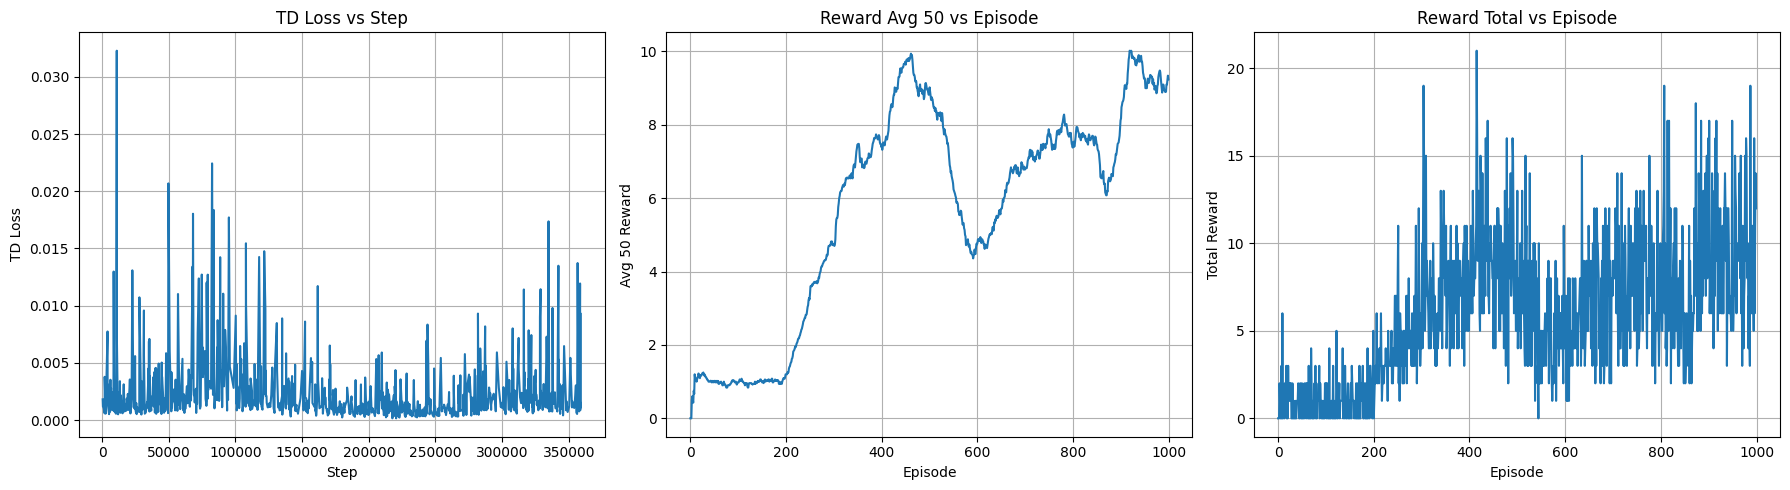

In [29]:
df1_tdloss = pd.read_csv("results/vanilla_dqn_1k_tdloss.csv")
df1_avg50 = pd.read_csv("results/vanilla_dqn_1k_avg50.csv")
df1_total = pd.read_csv("results/vanilla_dqn_1k_total.csv")

plot_three_metrics(df1_tdloss,df1_avg50,df1_total)


In [14]:
evaluate_model('models/best_vanilla_dqn_1k.pth', tag='vanilla_dqn_1k', dueling=False)
vids = [f for f in os.listdir('./videos/vanilla_dqn_1k') if f.endswith('.mp4')]
Video(f'./videos/vanilla_dqn_1k/{vids[-1]}', embed=True)

NameError: name 'evaluate_model' is not defined

#### Double DQN - 1000 Epdisodes

In [11]:
use_double_dqn = True
use_dueling_dqn = False
save_tag = 'double_dqn'  

train_dqn(episodes=1000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, use_per=False,save_tag=save_tag)



[Episode 0] New best avg reward: 0.00, model saved.
Episode 0 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
Episode 1 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
[Episode 2] New best avg reward: 0.33, model saved.
Episode 2 | Total Reward: 1.0 | Avg50: 0.33 | Epsilon: 0.99
[Episode 3] New best avg reward: 1.25, model saved.
Episode 3 | Total Reward: 4.0 | Avg50: 1.25 | Epsilon: 0.98
Episode 4 | Total Reward: 0.0 | Avg50: 1.00 | Epsilon: 0.98
Episode 5 | Total Reward: 0.0 | Avg50: 0.83 | Epsilon: 0.97
[Episode 6] New best avg reward: 1.29, model saved.
Episode 6 | Total Reward: 4.0 | Avg50: 1.29 | Epsilon: 0.97
[Episode 7] New best avg reward: 1.38, model saved.
Episode 7 | Total Reward: 2.0 | Avg50: 1.38 | Epsilon: 0.96
Episode 8 | Total Reward: 1.0 | Avg50: 1.33 | Epsilon: 0.96
[Episode 9] New best avg reward: 1.40, model saved.
Episode 9 | Total Reward: 2.0 | Avg50: 1.40 | Epsilon: 0.95
Episode 10 | Total Reward: 0.0 | Avg50: 1.27 | Epsilon: 0.95
Episode 11 | Total Reward: 

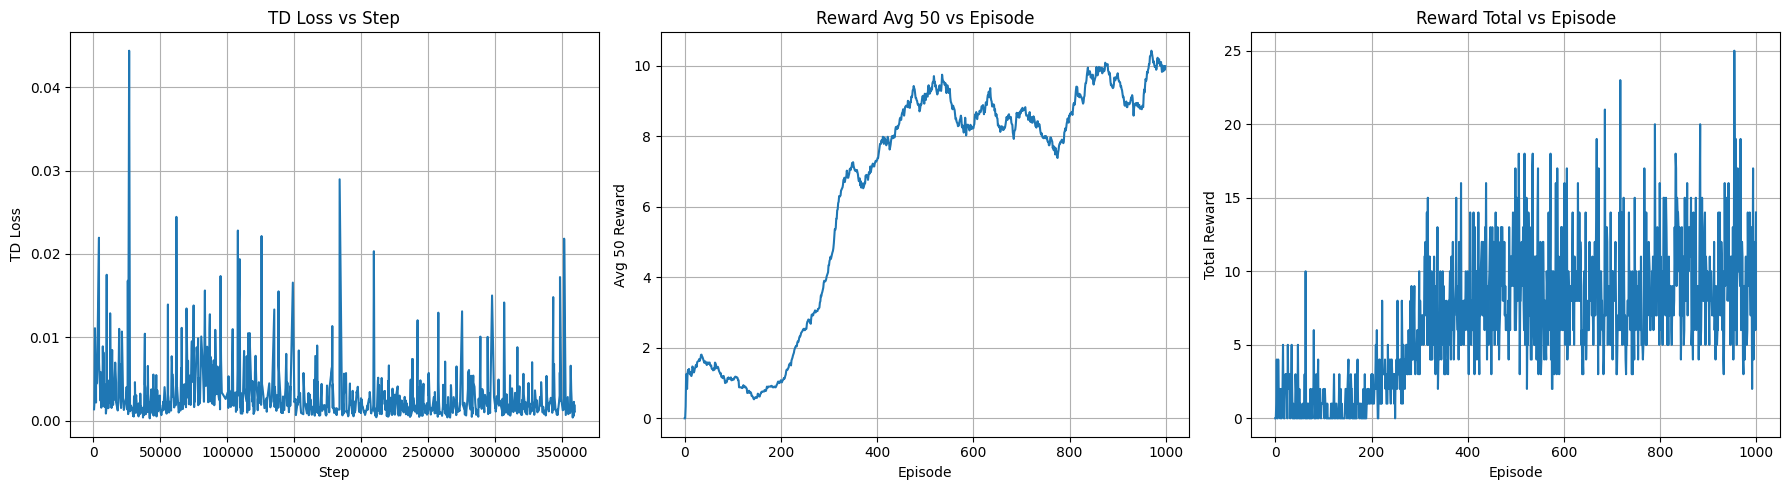

In [30]:
df2_tdloss = pd.read_csv("results/double_dqn_tdloss.csv")
df2_avg50 = pd.read_csv("results/double_dqn_avg50.csv")
df2_total = pd.read_csv("results/double_dqn_total.csv")

plot_three_metrics(df2_tdloss,df2_avg50,df2_total)

In [13]:
evaluate_model('models/best_double_dqn.pth', tag='double_dqn', dueling=False)
vids = [f for f in os.listdir('./videos/double_dqn') if f.endswith('.mp4')]
Video(f'./videos/double_dqn/{vids[-1]}', embed=True)

/home/sprince0031/.local/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn/rl-video-episode-0.mp4
Video saved at ./videos/double_dqn


#### Dueling DQN - 1000 Episodes

In [14]:
use_double_dqn = False
use_dueling_dqn = True
save_tag = 'dueling_dqn' 

train_dqn(episodes=1000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, use_per=False,save_tag=save_tag)

[Episode 0] New best avg reward: 2.00, model saved.
Episode 0 | Total Reward: 2.0 | Avg50: 2.00 | Epsilon: 0.99
[Episode 1] New best avg reward: 2.50, model saved.
Episode 1 | Total Reward: 3.0 | Avg50: 2.50 | Epsilon: 0.99
Episode 2 | Total Reward: 2.0 | Avg50: 2.33 | Epsilon: 0.99
[Episode 3] New best avg reward: 2.75, model saved.
Episode 3 | Total Reward: 4.0 | Avg50: 2.75 | Epsilon: 0.98
Episode 4 | Total Reward: 0.0 | Avg50: 2.20 | Epsilon: 0.98
Episode 5 | Total Reward: 1.0 | Avg50: 2.00 | Epsilon: 0.97
Episode 6 | Total Reward: 1.0 | Avg50: 1.86 | Epsilon: 0.97
Episode 7 | Total Reward: 1.0 | Avg50: 1.75 | Epsilon: 0.96
Episode 8 | Total Reward: 0.0 | Avg50: 1.56 | Epsilon: 0.96
Episode 9 | Total Reward: 1.0 | Avg50: 1.50 | Epsilon: 0.95
Episode 10 | Total Reward: 2.0 | Avg50: 1.55 | Epsilon: 0.95
Episode 11 | Total Reward: 1.0 | Avg50: 1.50 | Epsilon: 0.94
Episode 12 | Total Reward: 1.0 | Avg50: 1.46 | Epsilon: 0.94
Episode 13 | Total Reward: 4.0 | Avg50: 1.64 | Epsilon: 0.93


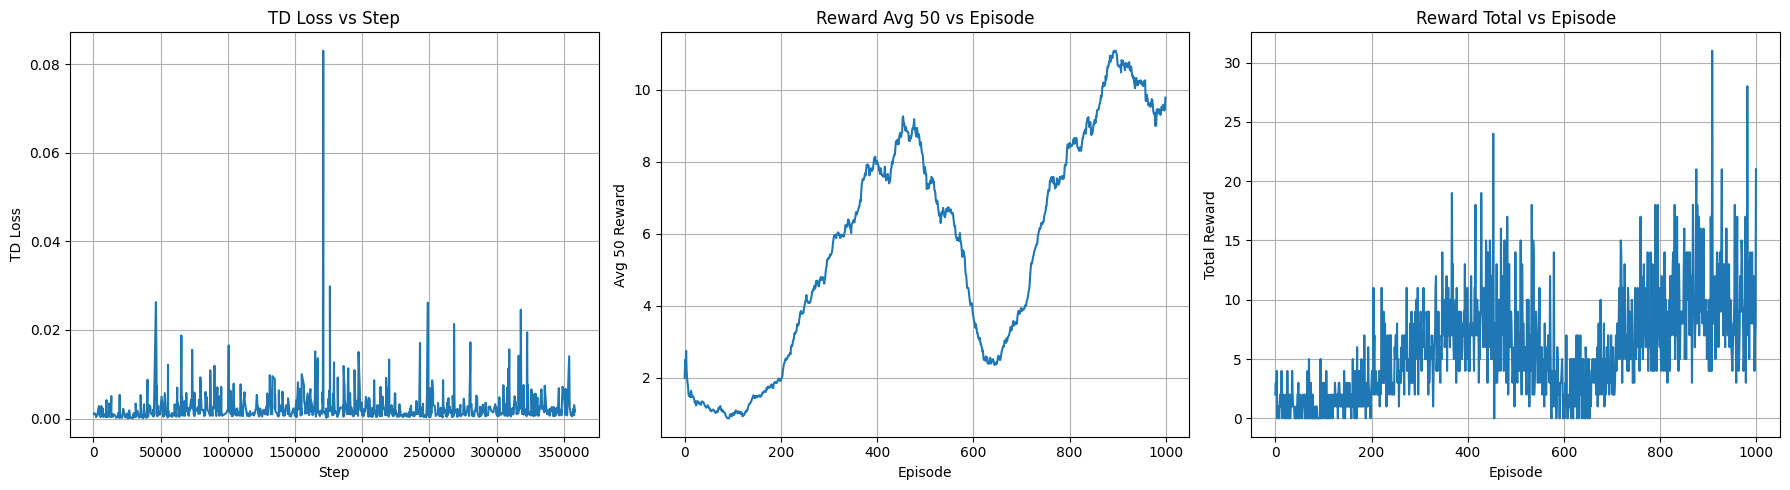

In [31]:
df3_tdloss = pd.read_csv("results/dueling_dqn_tdloss.csv")
df3_avg50 = pd.read_csv("results/dueling_dqn_avg50.csv")
df3_total = pd.read_csv("results/dueling_dqn_total.csv")

plot_three_metrics(df3_tdloss,df3_avg50,df3_total)

In [17]:
evaluate_model('models/best_dueling_dqn.pth', tag='dueling_dqn', dueling=True)
vids = [f for f in os.listdir('./videos/dueling_dqn') if f.endswith('.mp4')]
Video(f'./videos/dueling_dqn/{vids[-1]}', embed=True)

MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_dqn/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_dqn/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_dqn/rl-video-episode-0.mp4
Video saved at ./videos/dueling_dqn


#### Combination of Dueling + Double DQN - 1000 Episodes

In [18]:
use_double_dqn = True
use_dueling_dqn = True
save_tag = 'dueling_double_dqn'  

train_dqn(episodes=1000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, use_per=False,save_tag=save_tag)

[Episode 0] New best avg reward: 0.00, model saved.
Episode 0 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
Episode 1 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
Episode 2 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 0.99
[Episode 3] New best avg reward: 0.50, model saved.
Episode 3 | Total Reward: 2.0 | Avg50: 0.50 | Epsilon: 0.98
[Episode 4] New best avg reward: 0.60, model saved.
Episode 4 | Total Reward: 1.0 | Avg50: 0.60 | Epsilon: 0.98
[Episode 5] New best avg reward: 0.67, model saved.
Episode 5 | Total Reward: 1.0 | Avg50: 0.67 | Epsilon: 0.97
[Episode 6] New best avg reward: 0.71, model saved.
Episode 6 | Total Reward: 1.0 | Avg50: 0.71 | Epsilon: 0.97
Episode 7 | Total Reward: 0.0 | Avg50: 0.62 | Epsilon: 0.96
Episode 8 | Total Reward: 0.0 | Avg50: 0.56 | Epsilon: 0.96
Episode 9 | Total Reward: 0.0 | Avg50: 0.50 | Epsilon: 0.95
Episode 10 | Total Reward: 1.0 | Avg50: 0.55 | Epsilon: 0.95
[Episode 11] New best avg reward: 0.75, model saved.
Episode 11 | Total Reward:

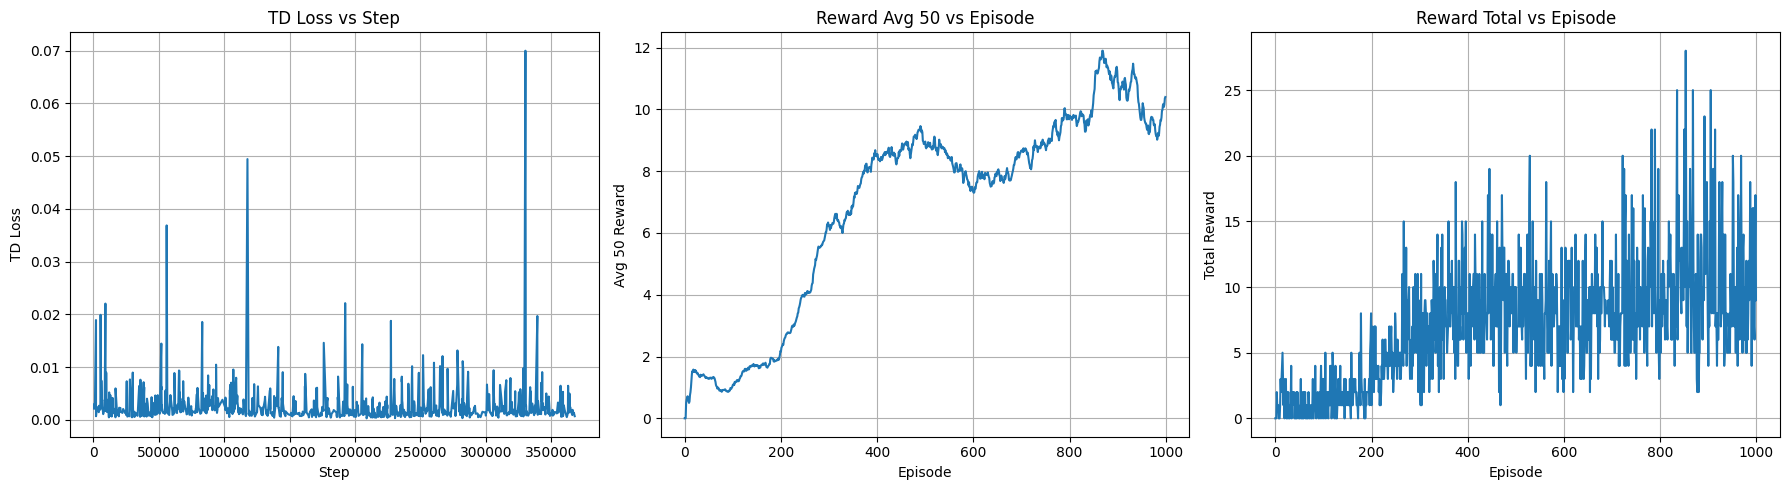

In [32]:
df4_tdloss = pd.read_csv("results/dueling_double_dqn_tdloss.csv")
df4_avg50 = pd.read_csv("results/dueling_double_dqn_avg50.csv")
df4_total = pd.read_csv("results/dueling_double_dqn_total.csv")

plot_three_metrics(df4_tdloss,df4_avg50,df4_total)

In [20]:
evaluate_model('models/best_dueling_double_dqn.pth', tag='dueling_double_dqn', dueling=True)
vids = [f for f in os.listdir('./videos/dueling_double_dqn') if f.endswith('.mp4')]
Video(f'./videos/dueling_double_dqn/{vids[-1]}', embed=True)

/home/sprince0031/.local/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_double_dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_double_dqn/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_double_dqn/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/dueling_double_dqn/rl-video-episode-0.mp4
Video saved at ./videos/dueling_double_dqn


#### Vanilla DQN - 10,000 Episodes

In [22]:
use_double_dqn = False
use_dueling_dqn = False
save_tag = 'vanilla_dqn_10k'

train_dqn(episodes=10000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9995, use_per=False,save_tag=save_tag)

[Episode 0] New best avg reward: 0.00, model saved.
Episode 0 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 1.00
[Episode 1] New best avg reward: 2.00, model saved.
Episode 1 | Total Reward: 4.0 | Avg50: 2.00 | Epsilon: 1.00
Episode 2 | Total Reward: 2.0 | Avg50: 2.00 | Epsilon: 1.00
[Episode 3] New best avg reward: 2.25, model saved.
Episode 3 | Total Reward: 3.0 | Avg50: 2.25 | Epsilon: 1.00
Episode 4 | Total Reward: 0.0 | Avg50: 1.80 | Epsilon: 1.00
Episode 5 | Total Reward: 1.0 | Avg50: 1.67 | Epsilon: 1.00
Episode 6 | Total Reward: 3.0 | Avg50: 1.86 | Epsilon: 1.00
[Episode 7] New best avg reward: 2.50, model saved.
Episode 7 | Total Reward: 7.0 | Avg50: 2.50 | Epsilon: 1.00
Episode 8 | Total Reward: 0.0 | Avg50: 2.22 | Epsilon: 1.00
Episode 9 | Total Reward: 2.0 | Avg50: 2.20 | Epsilon: 1.00
Episode 10 | Total Reward: 3.0 | Avg50: 2.27 | Epsilon: 0.99
Episode 11 | Total Reward: 2.0 | Avg50: 2.25 | Epsilon: 0.99
Episode 12 | Total Reward: 0.0 | Avg50: 2.08 | Epsilon: 0.99
Episode 1

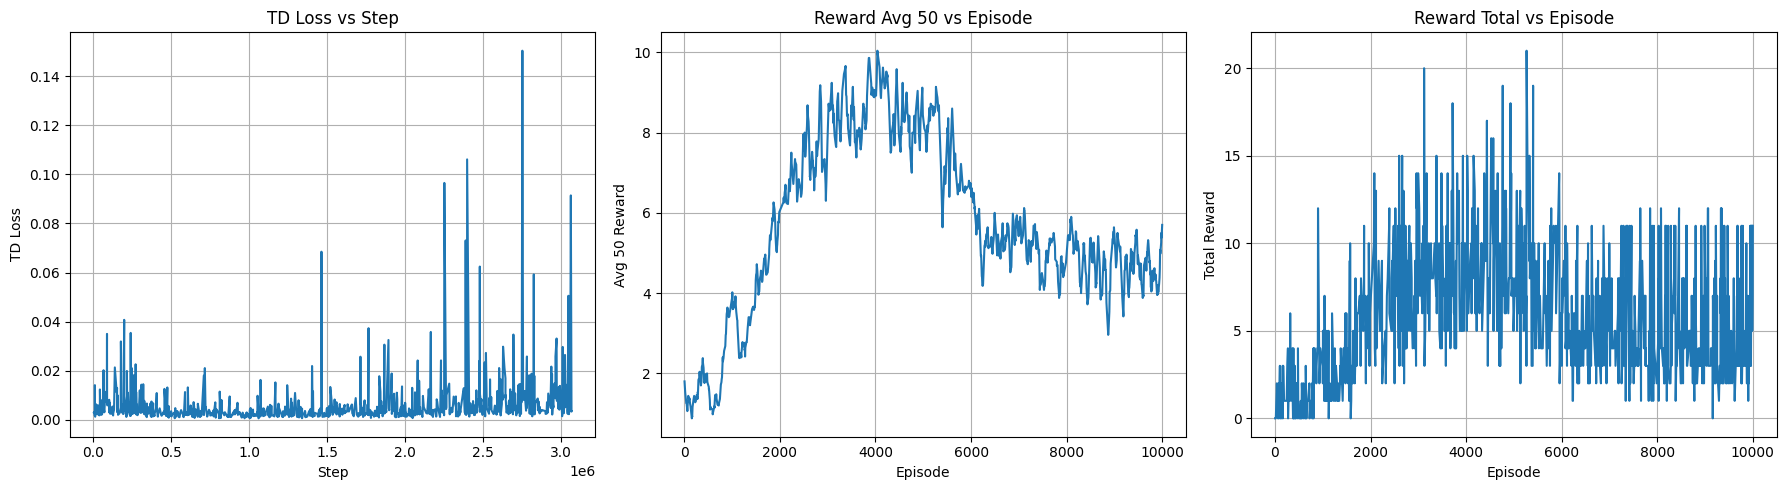

In [34]:
df5_tdloss = pd.read_csv("results/vanilla_dqn_10k_tdloss.csv")
df5_avg50 = pd.read_csv("results/vanilla_dqn_10k_avg50.csv")
df5_total = pd.read_csv("results/vanilla_dqn_10k_total.csv")

plot_three_metrics(df5_tdloss,df5_avg50,df5_total)

In [14]:
evaluate_model('models/best_vanilla_dqn_10k.pth', tag='vanilla_dqn_10k', dueling=False)
vids = [f for f in os.listdir('./videos/vanilla_dqn_10k') if f.endswith('.mp4')]
Video(f'./videos/vanilla_dqn_10k/{vids[-1]}', embed=True)

/home/sprince0031/.local/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/vanilla_dqn_10k folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/vanilla_dqn_10k/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/vanilla_dqn_10k/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/vanilla_dqn_10k/rl-video-episode-0.mp4
Video saved at ./videos/vanilla_dqn_10k


#### Double DQN - 10,000 Episodes

In [ ]:
use_double_dqn = True
use_dueling_dqn = False
save_tag = 'double_dqn_10k'  
save_dir = './models'
os.makedirs(save_dir, exist_ok=True)

train_dqn(episodes=10000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9995, use_per=False,save_tag=save_tag)


[Episode 0] New best avg reward: 0.00, model saved.
Episode 0 | Total Reward: 0.0 | Avg50: 0.00 | Epsilon: 1.00
[Episode 1] New best avg reward: 0.50, model saved.
Episode 1 | Total Reward: 1.0 | Avg50: 0.50 | Epsilon: 1.00
[Episode 2] New best avg reward: 1.00, model saved.
Episode 2 | Total Reward: 2.0 | Avg50: 1.00 | Epsilon: 1.00
Episode 3 | Total Reward: 1.0 | Avg50: 1.00 | Epsilon: 1.00
Episode 4 | Total Reward: 1.0 | Avg50: 1.00 | Epsilon: 1.00
Episode 5 | Total Reward: 0.0 | Avg50: 0.83 | Epsilon: 1.00
Episode 6 | Total Reward: 1.0 | Avg50: 0.86 | Epsilon: 1.00
Episode 7 | Total Reward: 1.0 | Avg50: 0.88 | Epsilon: 1.00
Episode 8 | Total Reward: 1.0 | Avg50: 0.89 | Epsilon: 1.00
Episode 9 | Total Reward: 2.0 | Avg50: 1.00 | Epsilon: 1.00
[Episode 10] New best avg reward: 1.09, model saved.
Episode 10 | Total Reward: 2.0 | Avg50: 1.09 | Epsilon: 0.99
Episode 11 | Total Reward: 0.0 | Avg50: 1.00 | Epsilon: 0.99
Episode 12 | Total Reward: 0.0 | Avg50: 0.92 | Epsilon: 0.99
Episode 

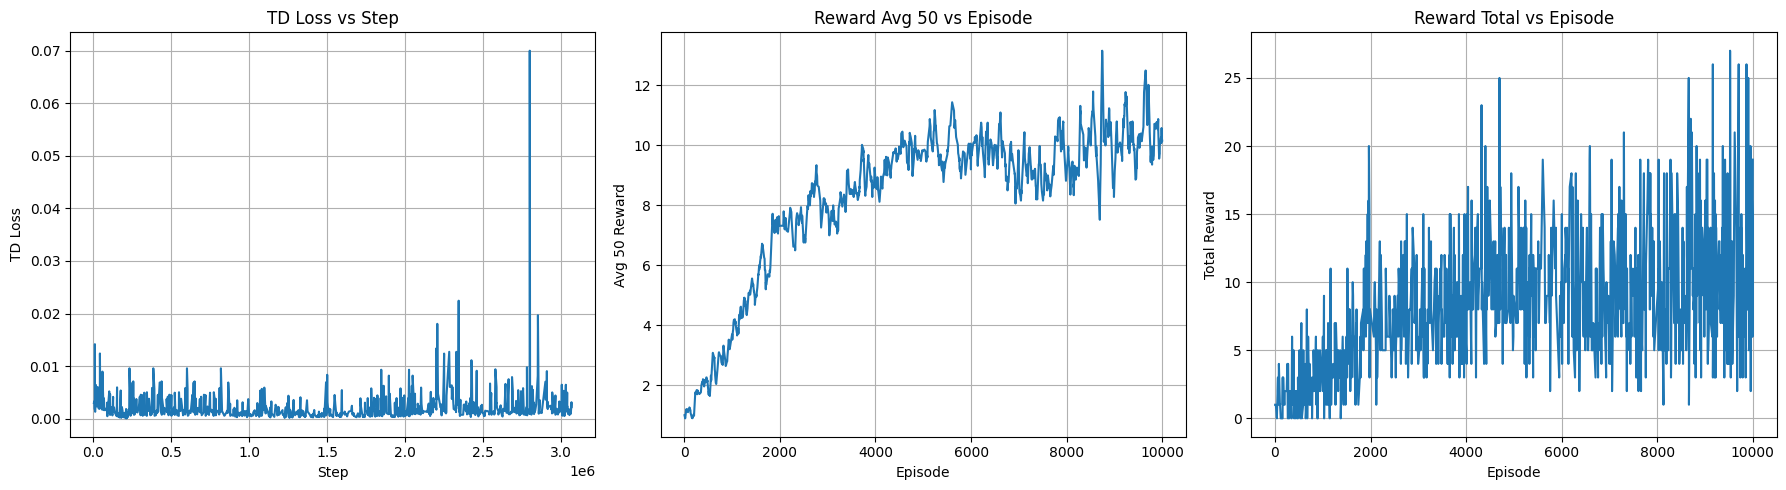

In [35]:
df6_tdloss = pd.read_csv("results/double_dqn_10k_tdloss.csv")
df6_avg50 = pd.read_csv("results/double_dqn_10k_avg50.csv")
df6_total = pd.read_csv("results/double_dqn_10k_total.csv")

plot_three_metrics(df6_tdloss,df6_avg50,df6_total)

In [13]:
evaluate_model('models/best_double_dqn_10k.pth', tag='double_dqn_10k', dueling=False)
vids = [f for f in os.listdir('./videos/double_dqn_10k') if f.endswith('.mp4')]
Video(f'./videos/double_dqn_10k/{vids[-1]}', embed=True)

MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn_10k/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn_10k/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn_10k/rl-video-episode-0.mp4
Video saved at ./videos/double_dqn_10k


#### Double DQN - 10,000 Episodes with PER

In [ ]:
use_double_dqn = True
use_dueling_dqn = False
save_tag = 'double_dqn_10k_per'  

train_dqn(episodes=10000, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9995, use_per=True,save_tag=save_tag)

[Episode 0] New best avg reward: 2.00, model saved.
Episode 0 | Total Reward: 2.0 | Avg50: 2.00 | Epsilon: 1.00
Episode 1 | Total Reward: 0.0 | Avg50: 1.00 | Epsilon: 1.00
Episode 2 | Total Reward: 1.0 | Avg50: 1.00 | Epsilon: 1.00
Episode 3 | Total Reward: 1.0 | Avg50: 1.00 | Epsilon: 1.00
Episode 4 | Total Reward: 3.0 | Avg50: 1.40 | Epsilon: 1.00
Episode 5 | Total Reward: 3.0 | Avg50: 1.67 | Epsilon: 1.00
Episode 6 | Total Reward: 2.0 | Avg50: 1.71 | Epsilon: 1.00
[Episode 7] New best avg reward: 2.12, model saved.
Episode 7 | Total Reward: 5.0 | Avg50: 2.12 | Epsilon: 1.00
Episode 8 | Total Reward: 0.0 | Avg50: 1.89 | Epsilon: 1.00
Episode 9 | Total Reward: 1.0 | Avg50: 1.80 | Epsilon: 1.00
Episode 10 | Total Reward: 0.0 | Avg50: 1.64 | Epsilon: 0.99
Episode 11 | Total Reward: 0.0 | Avg50: 1.50 | Epsilon: 0.99
Episode 12 | Total Reward: 1.0 | Avg50: 1.46 | Epsilon: 0.99
Episode 13 | Total Reward: 2.0 | Avg50: 1.50 | Epsilon: 0.99
Episode 14 | Total Reward: 1.0 | Avg50: 1.47 | Epsil

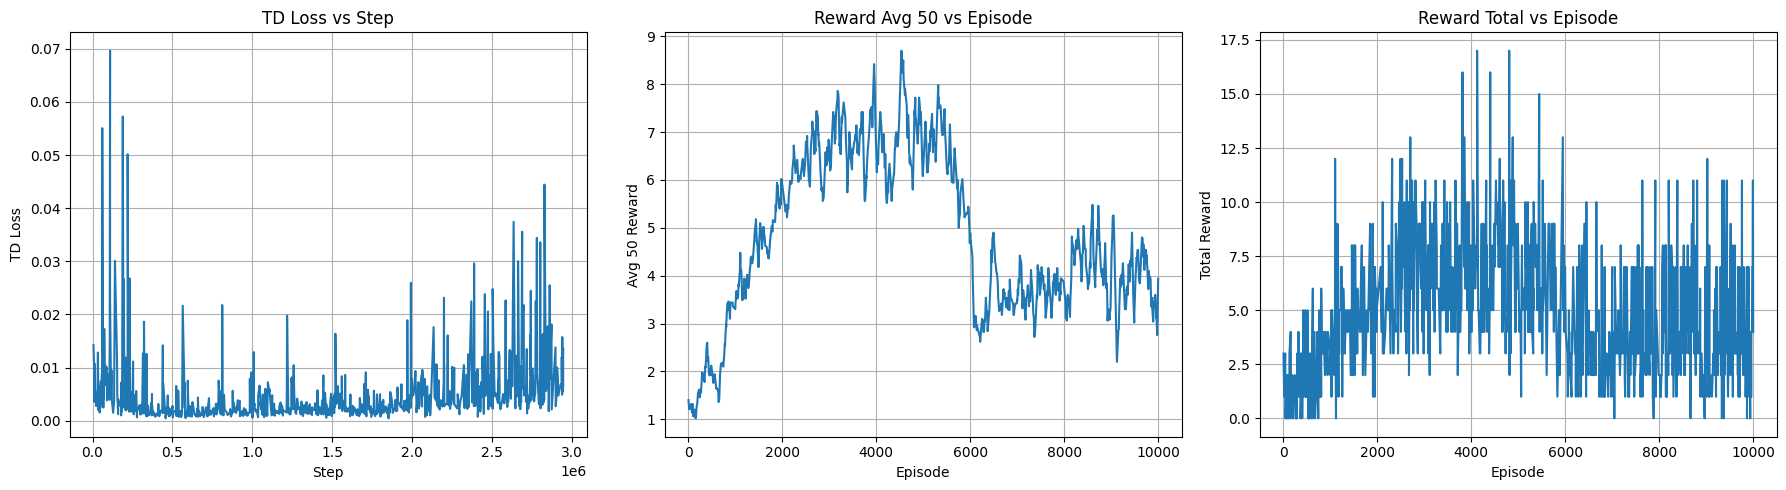

In [5]:
df7_tdloss = pd.read_csv("results/double_dqn_10k_per_tdloss.csv")
df7_avg50 = pd.read_csv("results/double_dqn_10k_per_avg50.csv")
df7_total = pd.read_csv("results/double_dqn_10k_per_total.csv")

plot_three_metrics(df7_tdloss,df7_avg50,df7_total)

In [12]:
evaluate_model('models/best_double_dqn_10k_per.pth', tag='double_dqn_10k_per', dueling=False)
vids = [f for f in os.listdir('./videos/double_dqn_10k_per') if f.endswith('.mp4')]
Video(f'./videos/double_dqn_10k_per/{vids[-1]}', embed=True)

MoviePy - Building video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn_10k_per/rl-video-episode-0.mp4.
MoviePy - Writing video /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn_10k_per/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/sprince0031/Thendral/Code/DQN Project/atari_breakout_dqn/videos/double_dqn_10k_per/rl-video-episode-0.mp4
Video saved at ./videos/double_dqn_10k_per


### **Results and Discussion**

##### Utility Function for Plotting Results

In [ ]:
def plot_metrics(ax, dfs, labels, title, xlabel, ylabel):

    for df, label in zip(dfs, labels):
        ax.plot(df["Step"], df["Value"], label=label)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()


#### Results for 1000 episode experiments

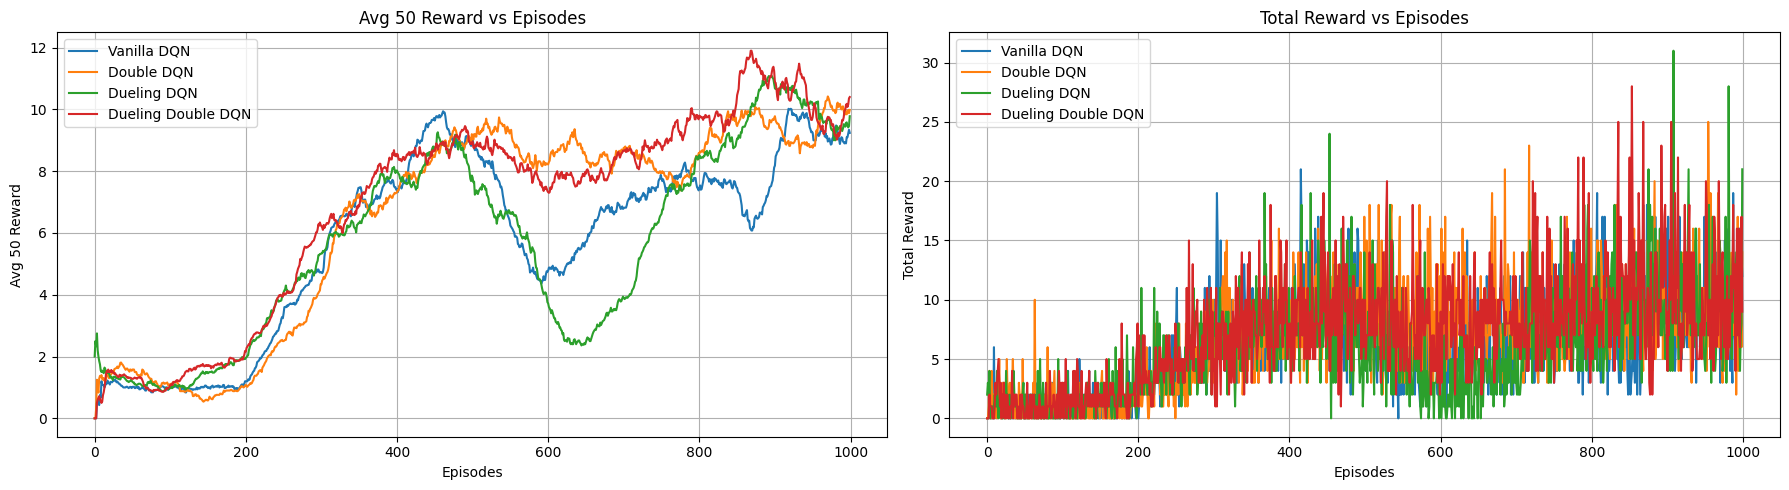

In [ ]:
labels = ["Vanilla DQN", "Double DQN", "Dueling DQN", "Dueling Double DQN"]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

plot_metrics(axs[0], [df1_avg50, df2_avg50, df3_avg50, df4_avg50], labels,
             "Avg 50 Reward vs Episodes", "Episodes", "Avg 50 Reward")

plot_metrics(axs[1], [df1_total, df2_total, df3_total, df4_total], labels,
             "Total Reward vs Episodes", "Episodes", "Total Reward")

plt.tight_layout()
plt.show()


This plot compares the performance of four reinforcement learning models: **Vanilla DQN**, **Double DQN**, **Dueling DQN**, and **Dueling Double DQN** over 1,000 training episodes. The left graph shows the **average reward over the last 50 episodes**, giving us a smoothed view of how consistently each model performs over time. We can see that **Dueling Double DQN** learns faster and reaches higher stable performance than the others, especially after episode 400. The right graph shows the **total reward per episode**, which fluctuates more, especially early on. While all models improve over time, the reward spikes are more frequent and higher for **Dueling Double DQN** and **Dueling DQN**, suggesting that they make better decisions in key moments. Overall, the combined dueling and double approach appears to offer the most consistent and high-performing learning behavior in this setup.


#### Results for experiments over 10,000 episodes

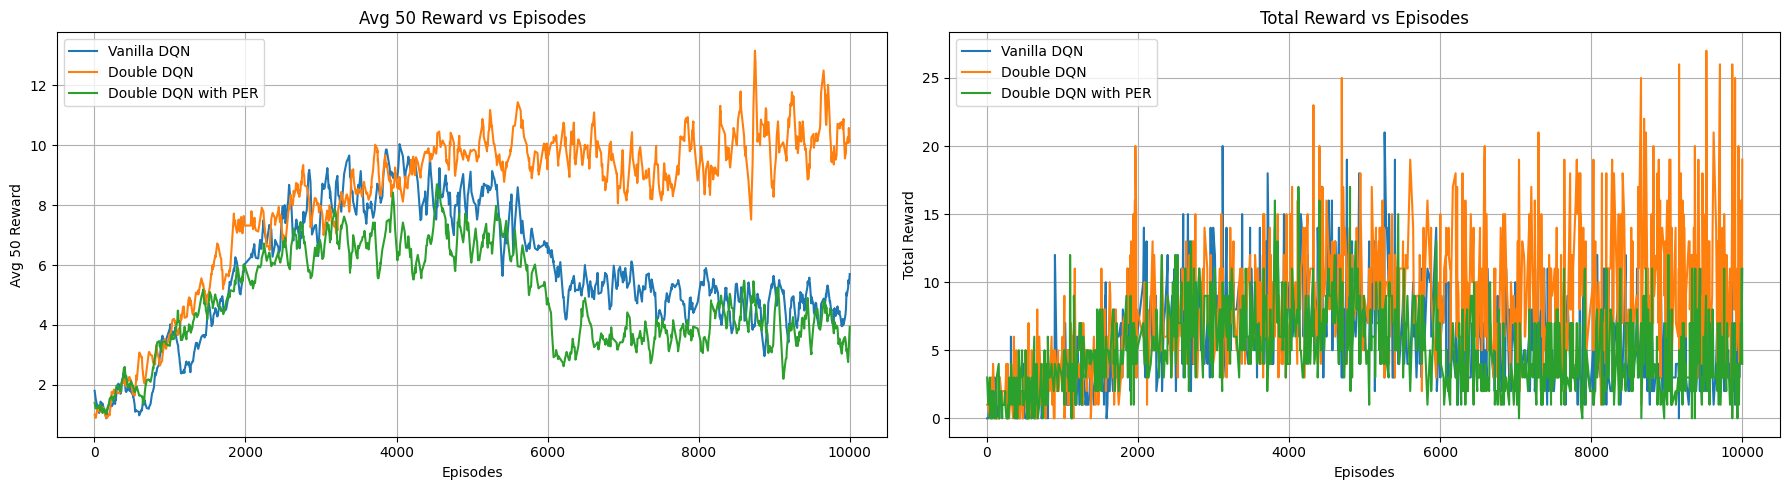

In [ ]:
labels = ["Vanilla DQN", "Double DQN","Double DQN with PER"]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

plot_metrics(axs[0], [df5_avg50, df6_avg50, df7_avg50], labels,
             "Avg 50 Reward vs Episodes", "Episodes", "Avg 50 Reward")

plot_metrics(axs[1], [df5_total, df6_total, df7_total], labels,
             "Total Reward vs Episodes", "Episodes", "Total Reward")


plt.tight_layout()
plt.show()

This plot compares the performance of Vanilla DQN, Double DQN, and Double DQN with Prioritized Experience Replay (PER) over 10,000 training episodes. The left graph shows the smoothed average reward over the last 50 episodes, while the right graph shows the total reward per episode. Double DQN performs the best, reaching a stable and higher average reward after around 2,000 episodes. Vanilla DQN performs reasonably well but fluctuates more. Surprisingly, Double DQN with PER underperforms both, maintaining a lower average reward and failing to improve beyond a certain point.

**This underperformance of PER could be due to several factors:**

- **Over-sampling high-error transitions too early:** If PER aggressively samples transitions with high TD error early in training, it can lead to instability or overfitting on outliers before the value function has stabilized.

- **Lack of proper prioritization scaling:** PER introduces additional hyperparameters like the priority exponent(alpha) and importance-sampling correction(beta). If these are not tuned correctly (e.g., alpha too high or beta too low), the agent may not benefit from prioritization and might even learn from noisy or misleading experiences.

- **Noisy TD error estimates:** In early training, TD error is volatile and may not be a reliable signal for prioritization. This can cause the replay buffer to focus on the wrong samples.

- **Insufficient exploration:** PER tends to replay the same high-error transitions more often, which can reduce sample diversity and exploration, especially in long training runs.

While PER is designed to accelerate learning by focusing on “important” experiences, it requires careful tuning and may harm performance if the prioritization is too aggressive or misaligned with the learning phase. This plot suggests that in this 10k-episode run, PER did not have enough exploration balance or stability to outperform standard Double DQN.